# Visualization of a Simple Stochastic Gradient Descent using PyTorch DistributedDataParallel

Now let's see the standard DistributedDataParallel from PyTorch, which automatically synchronizes the initial model weights and gradients across the different nodes.

Exercise: Go over the notebook and replace the comments with the corresponding lines of DistributedDataParallel:
```python
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

dist.init_process_group(backend="nccl")

# data sharding: divide the data equally between the nodes
sampler = data.distributed.DistributedSampler(dataset, rank=dist.get_rank())
loader = data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# broadcast weights and setup all-reduce hooks to average gradients during the backward pass
dist_model = DDP(model)
```
Exercise: Check if the data sharding, model weight broadcast, and gradient averaging are working as expected.

In [1]:
import os
import socket
import ipcmagic
%ipcluster start -n 2 --mpi

  0%|          | 0/2 [00:00<?, ?engine/s]

In [2]:
%%px
%reload_ext autoreload
%autoreload 2

import os
import sys
import socket
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils import data

from tqdm.std import trange, tqdm

from line_regression import get_line_data, plot_regression

## Setup environment for torch.distributed

In [3]:
%%px
# Setup environment for torch.distributed.init_process_group
os.environ['MASTER_PORT'] = '29500'
os.environ['WORLD_SIZE'] = os.environ['SLURM_NNODES']
os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = os.environ['SLURM_NODEID']

In [4]:
master_address = f"'{socket.gethostname()}'"
%px os.environ['MASTER_ADDR'] = $master_address

%px print(os.environ['MASTER_ADDR'])

[stdout:1] nid07206
[stdout:0] nid07206


## Initialize torch.distributed

In [5]:
%%px
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

if not dist.is_initialized():
    # Environment variable initialization
    dist.init_process_group(backend="nccl")

world_size = dist.get_world_size()
rank = dist.get_rank()

print(socket.gethostname(), rank, world_size)

[stdout:0] nid07206 0 2
[stdout:1] nid07207 1 2


## Dataset
Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

In [6]:
%%px
nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

print(ground_truth)

[stdout:1] [2.0, 0.0]
[stdout:0] [2.0, 0.0]


[output:0]

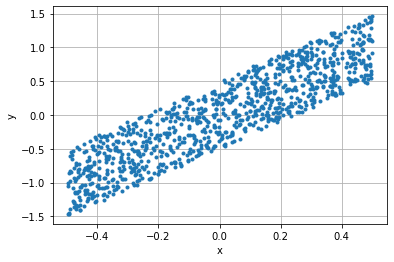

In [7]:
%%px --target 0
plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Input pipeline

In [8]:
%%px
batch_size = 100

# GPU Tensors
device = 'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

dataset = data.TensorDataset(x, y)

### Task 1: Setup the DistributedSampler
### https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler
### to load a subset of the original dataset that is exclusive to each rank
sampler = #TODO
loader = data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [9]:
# # check sharded data
# first_batch = next(iter(loader))
# first_batch[0].ravel()

#### Inspect sizes:

In [10]:
%%px --target 0
print(dict(dataset_items=len(dataset), batch_size=batch_size, loader_items=len(loader), world_size=world_size))

assert batch_size * len(loader) * world_size == len(dataset)

[stdout:0] {'dataset_items': 1000, 'batch_size': 100, 'loader_items': 5, 'world_size': 2}


## Define distributed model

In [11]:
%%px
model = nn.Linear(1, 1, bias=True, device=device)

### Task 2: wrap the model with DistributedDataParallel (DDP)
### check that all parameters were properly synchronized
### https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html
dist_model = (model) # TODO change this line

dict(model.named_parameters())

[stdout:0] 
nid07206:27083:27083 [0] NCCL INFO Bootstrap : Using [0]ipogif0:148.187.60.95<0>
nid07206:27083:27083 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so), using internal implementation
nid07206:27083:27083 [0] NCCL INFO NET/IB : No device found.
nid07206:27083:27083 [0] NCCL INFO NET/Socket : Using [0]ipogif0:148.187.60.95<0>
nid07206:27083:27083 [0] NCCL INFO Using network Socket
NCCL version 2.7.8+cuda11.1
nid07206:27083:27118 [0] NCCL INFO Channel 00/02 :    0   1
nid07206:27083:27118 [0] NCCL INFO Channel 01/02 :    0   1
nid07206:27083:27118 [0] NCCL INFO threadThresholds 8/8/64 | 16/8/64 | 8/8/64
nid07206:27083:27118 [0] NCCL INFO Trees [0] 1/-1/-1->0->-1|-1->0->1/-1/-1 [1] -1/-1/-1->0->1|1->0->-1/-1/-1
nid07206:27083:27118 [0] NCCL INFO Setting affinity for GPU 0 to ffffff
nid07206:27083:27118 [0] NCCL INFO Channel 00 : 1[2000] -> 0[2000] [receive] via NET/Socket/0
nid07206:27083:27118 [0] NCCL INFO Channel 00 : 0[2000] -> 1[2000] [send] via NET/Socket/0
nid0

[stderr:0] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.
[stderr:1] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


Out[0:10]: 
{'weight': Parameter containing:
 tensor([[0.4955]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.7471], device='cuda:0', requires_grad=True)}

Out[1:8]: 
{'weight': Parameter containing:
 tensor([[0.4955]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.7471], device='cuda:0', requires_grad=True)}

In [12]:
%%px --noblock -o training
epochs = 1000
lr = 0.0005 * batch_size**0.5
history = []

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

for epoch in trange(epochs, file=sys.__stdout__):
    # Sampler will reshuffle all data every epoch
    sampler.set_epoch(epoch)
    for i, batch in enumerate(loader):
        data, target = batch

        # Calculate loss
        y_hat = dist_model(data)
        mse = F.mse_loss(y_hat, target)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Calculate gradients
        mse.backward()
        # Training step
        optimizer.step()

        history.append([model.weight.item(), model.bias.item(), mse.item()])

<AsyncResult: execute>

In [13]:
# watch the output in real time
from ipcmagic import utilities
utilities.watch_asyncresult(training)

[ stdout 0 ]
100%|██████████| 1000/1000 [00:13<00:00, 73.16it/s]
[ stdout 1 ]
100%|██████████| 1000/1000 [00:13<00:00, 73.16it/s]


[output:0]

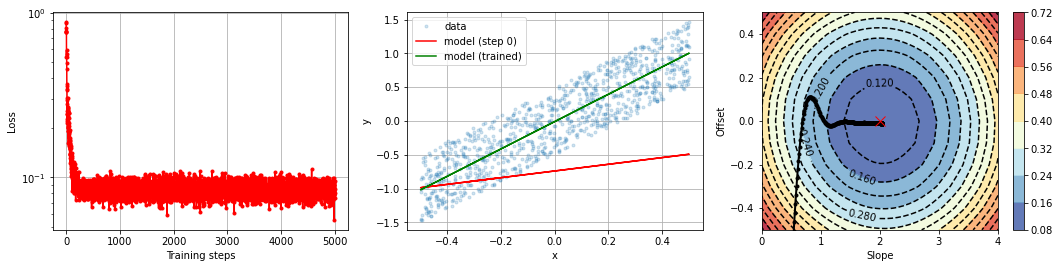

[output:1]

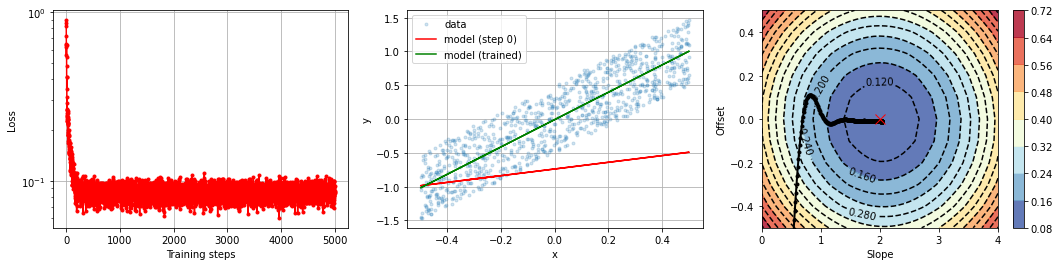

Out[0:12]: 
{'weight': Parameter containing:
 tensor([[2.0294]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.0095], device='cuda:0', requires_grad=True)}

Out[1:10]: 
{'weight': Parameter containing:
 tensor([[2.0294]], device='cuda:0', requires_grad=True),
 'bias': Parameter containing:
 tensor([-0.0095], device='cuda:0', requires_grad=True)}

In [14]:
%%px
plot_regression(history, x_train, y_train, ground_truth)

dict(model.named_parameters())

In [15]:
%ipcluster stop